# Introduction
The "We Rate Dogs" Twitter archive contains over 5000 tweets, The goal of this project is wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import tweepy
import json
import requests
import os
import time
import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline


# Gathering Data

## Enhanced Twitter Archive
Importing twitter-archive-enhanced.csv file which is download manually from the Udacity server.

In [2]:
df_archive = pd.read_csv("twitter-archive-enhanced.csv")

In [3]:
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None



## Image Predictions File
Importing image_predictions.tsv file programmatically from URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [6]:
# downloading the image predictions file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [5]:
# Check if response succeeded
response

<Response [200]>

In [7]:
# Creating a folder to save the file in it
images_folder = 'images'
if not os.path.exists(images_folder):
    os.makedirs(images_folder)

In [8]:
#  Saving the file into the images folder
with open(os.path.join(images_folder, url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

In [9]:
# Check that the file has already saved into the folder
os.listdir(images_folder)

['image-predictions.tsv']

In [10]:
# read images file into a DataFrame
df_predictions = pd.read_csv('./images/image-predictions.tsv', sep = '\t')

In [11]:
df_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## Tweet JSON Data Downloading
Querying the Twitter API for each tweet's JSON data using Python's Tweepy library and storing each tweet's entire set of JSON data in a file called tweet_json.txt file.

In [12]:
# Authorization keys
consumer_key = ""
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify= True)


In [18]:

# Downloading with the Twitter API

# getting the tweets ID from twitter_archive file
tweet_ids = df_archive['tweet_id'].values

count = 0
error_msg = {}

start = time.time() #To be used in elapsed_time calculation

# saving the tweets' data in the list to a text file in json formating
if not os.path.isfile('tweet_json.txt'):
    # create the file and write on it
    with open ('tweet_json.txt', 'w') as file:
        for tweet_id in df_archive['tweet_id']:
            try:
                # Getting the tweet's data and append them to the jason list
                tweet = api.get_status(tweet_id, tweet_mode = 'extended')
                json.dump(tweet._json, file)
                file.write('\n')
            # save the error to the fail dictionary for review
            except tweepy.TweepError as error:   
                error_msg[tweet_id] = error
                print('Tweed id: {} error: {}'.format(tweet_id, error_msg[tweet_id]))
                continue
            count += 1
            # printing the loop counting     
            if count in (250, 750, 1500, 2200):
                print("loop {} ".format(count))
# printing the total number of errors 
print("The number of Errors:  {}\n".format(len(error_msg)))

# Printing the elapsed_time
end = time.time()
print("\nThe elapsed time = {}".format(end - start)) 
    

Tweed id: 888202515573088257 error: [{'code': 144, 'message': 'No status found with that ID.'}]
Tweed id: 873697596434513921 error: [{'code': 144, 'message': 'No status found with that ID.'}]
Tweed id: 872668790621863937 error: [{'code': 144, 'message': 'No status found with that ID.'}]
Tweed id: 872261713294495745 error: [{'code': 144, 'message': 'No status found with that ID.'}]
Tweed id: 869988702071779329 error: [{'code': 144, 'message': 'No status found with that ID.'}]
Tweed id: 866816280283807744 error: [{'code': 144, 'message': 'No status found with that ID.'}]
Tweed id: 862457590147678208 error: Failed to send request: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
Tweed id: 861769973181624320 error: [{'code': 144, 'message': 'No status found with that ID.'}]
Tweed id: 856602993587888130 error: [{'code': 144, 'message': 'No status found with that ID.'}]
Tweed id: 851953902622658560 error:

Rate limit reached. Sleeping for: 218


Tweed id: 759566828574212096 error: [{'code': 144, 'message': 'No status found with that ID.'}]
Tweed id: 754011816964026368 error: [{'code': 144, 'message': 'No status found with that ID.'}]
Tweed id: 742423170473463808 error: Failed to send request: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
Tweed id: 728387165835677696 error: Failed to send request: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
loop 1500 
Tweed id: 680055455951884288 error: [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 182


Tweed id: 672264251789176834 error: Failed to send request: ('Connection aborted.', OSError(0, 'Error'))
Tweed id: 672256522047614977 error: Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Read timed out. (read timeout=60)
Tweed id: 672254177670729728 error: Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Max retries exceeded with url: /1.1/statuses/show.json?id=672254177670729728&tweet_mode=extended (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000025029AB7AC0>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))
Tweed id: 668815180734689280 error: Failed to send request: ('Connection aborted.', OSError(0, 'Error'))
Tweed id: 668779399630725120 error: Failed to send request: HTTPSConnectionPool(host='api.

In [12]:
# Reading the json file

tweets_data = []

with open('tweet_json.txt', encoding='UTF-8') as json_file:
    # Read the first line
    for line in json_file:
        tweet = json.loads(line) # To convert the dtype of 'line' from str to dictionary.
        # Extract variables from the 'tweet' dictionary
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        user_count = tweet['user']['followers_count']
        # Create a dictionary with the JSON data and add it to the 'tweets_data' list.
        tweets_data.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count,
                       'user_count': user_count})

# Convert the data in the 'tweets_data' list to a DataFrame
df_api_data = pd.DataFrame(tweets_data, 
                                   columns = ['tweet_id',
                                              'retweet_count',
                                              'favorite_count','user_count'])

df_api_data.head()

,tweet_id,retweet_count,favorite_count,user_count
0,892420643555336193,7341,34986,8982820
1,892177421306343426,5478,30294,8982820
2,891815181378084864,3621,22788,8982820
3,891689557279858688,7530,38250,8982820
4,891327558926688256,8110,36532,8982820


In [13]:
# Saving the dataframe to a CSV file
df_api_data.to_csv('tweet_api_data.csv', index = False)

# Assess Data
In this section I assess the data that was gathered, both visually and programmatically for quality and tidiness issues.

In [14]:
# Load the data gathered data files
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_predictions = pd.read_csv('./images/image-predictions.tsv', sep = '\t')
df_api = pd.read_csv('tweet_api_data.csv')

## Enhanced Twitter Archive

In [15]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [25]:
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [26]:
df_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [27]:
# Checking for duplicated data
sum(df_archive.duplicated())

0

In [28]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [106]:
# Checking the name column.
df_archive.name.value_counts()

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
          ... 
Yoda         1
all          1
Pinot        1
Sailor       1
Nigel        1
Name: name, Length: 957, dtype: int64

In [115]:
df_archive.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2], dtype=int64)

In [109]:
df_archive.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88], dtype=int64)

### Quality issues in df_archive

- There are 181 retweets (`retweeted_status_id`)
- `name` column has missing and incorrect values e.g. "an", "None".
- The data type for tumestamp is string.
- There are 78 replies (`in_reply_to_status_id`).
- There are only 2297 tweets with linked to images; so 59 tweets are without images.
- The `rating_numerator` and `rating_denominator` columns have incorrect values as (0, 1776, 170, 5, 6) 
- The `expanded_urls` column has some repeated urls in the same cell.

### Tidiness issues in df_archive:

- There are 4 columns for dog stages (doggo, floofer, pupper, puppo) instead of one "dog_stage"


## Image Predictions File

In [30]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [31]:
df_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [32]:
df_predictions.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [33]:
df_predictions.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [34]:
df_predictions.p2_dog.value_counts()


True     1553
False     522
Name: p2_dog, dtype: int64

In [35]:
df_predictions.p3_dog.value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [36]:
df_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1923,857029823797047296,https://pbs.twimg.com/media/C-TIEwMW0AEjb55.jpg,2,golden_retriever,0.968623,True,Labrador_retriever,0.010325,True,Saluki,0.004148,True
269,670815497391357952,https://pbs.twimg.com/media/CU83IZ8W4AEIh4y.jpg,1,American_Staffordshire_terrier,0.919714,True,Staffordshire_bullterrier,0.073430,True,bull_mastiff,0.000906,True
316,671743150407421952,https://pbs.twimg.com/media/CVKC1IfWIAAsQks.jpg,1,toy_poodle,0.419427,True,miniature_poodle,0.237067,True,swing,0.104193,False
730,686618349602762752,https://pbs.twimg.com/media/CYdbvwjWcAEtjYu.jpg,1,Rottweiler,0.441331,True,miniature_pinscher,0.233180,True,Gordon_setter,0.093582,True
707,685169283572338688,https://pbs.twimg.com/media/CYI10WhWsAAjzii.jpg,1,Bernese_mountain_dog,0.975096,True,Appenzeller,0.014578,True,EntleBucher,0.005943,True


In [38]:
df_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [39]:
df_predictions.duplicated().sum()

0

### Quality issues in df_predictions
- There are 2075 image predictions only,the rest will be classified as "missing data".
- There are three columns to indicate is_dog, it is better to add another one depending on them to be used for filtering purposes.
- The data is clean regardless it may contain retweets or replies.
- The columns' names are not describtive.


### Tidiness issues in df_predictions
- The data is tidy.

## Json Data File

In [16]:
df_api_data.sample(10)

,tweet_id,retweet_count,favorite_count,user_count
1947,672995267319328768,268,883,8982853
2214,667866724293877760,941,2813,8982923
1630,683111407806746624,869,3264,8982837
1006,745314880350101504,2624,6889,8982861
679,786286427768250368,2768,7841,8982847
147,862096992088072192,20901,68689,8982826
18,888554962724278272,3006,17913,8982820
131,866094527597207552,7502,0,8982825
1021,743510151680958465,3560,7640,8982862
602,796080075804475393,2257,8341,8982841


In [41]:
df_api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2317 entries, 0 to 2316
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2317 non-null   int64
 1   retweet_count   2317 non-null   int64
 2   favorite_count  2317 non-null   int64
 3   user_count      2317 non-null   int64
dtypes: int64(4)
memory usage: 72.5 KB


In [42]:
df_api_data.describe()

,tweet_id,retweet_count,favorite_count,user_count
count,2.317000e+03,2317.000000,2317.000000,2.317000e+03
mean,7.421519e+17,2592.530859,7332.649547,8.982859e+06
std,6.821209e+16,4382.643170,11369.530904,6.510125e+01
min,6.660209e+17,1.000000,0.000000,8.982820e+06
25%,6.783997e+17,527.000000,1287.000000,8.982833e+06
50%,7.185406e+17,1210.000000,3180.000000,8.982845e+06
75%,7.986825e+17,2994.000000,8960.000000,8.982862e+06
max,8.924206e+17,74194.000000,150369.000000,8.983467e+06


### Quality and Tidiness issues in df_api_data
- The data is clean and tidy regardless it may contain retweets or replies.

## Assessment Summary

### Quality
#### archive
- The `name` column represents the dog names which are all capitalized, so words that begin in lowercase are not a dogs' name as ("a", "the" and "an"). (Quality solved issue no.1)
- There are 181 retweets (`retweeted_status_id`) and there are 78 replies (`in_reply_to_status_id`).(Quality solved issue no.2)
- There are three columns to indicate is_dog, it is better to add another one depending on them to be used for filtering purposes.(Quality solved issue no.3)
- There are only 2297 tweets with linked to images; so 59 tweets are without images. (Quality solved issue no.4)
- The following redundant columns (in_reply_to_user_id, 'retweeted_status_user_id', 'retweeted_status_timestamp') may needs to be droped (Quality solved issue no.5)
- The `rating_denominator` column has incorrect values as (0, 2, 170, 6)  (Quality solved issue no.6)
- The `rating_numerator` column has incorrect values as (70, 7, 150, 11, 2).(Quality solved issue no.7 and no.8)
- The data type for tumestamp is string and it contains '+0000' string. (Quality solved issue no.9 and no.10)
- The `expanded_urls` column has some repeated urls in the same cell.(Solved during cleanig)

#### predictions
- There are 2075 image predictions only,the rest will be classified as "missing data".
- The columns' names are not describtive.
- It may contain retweets or replies.

#### json_data
- It may contain retweets or replies.

### Tidiness
#####   archive
- There are 4 columns for dog stages (doggo, floofer, pupper, puppo) instead of one "dog_stage" (Tidiness solved issue no.1)
#### json_data
-  The `json_data` table should be combined with the `archive` table. (Tidiness solved issue no.2)

# Clean Data

In [17]:
# make copies of the original data for cleaning.
archive_clean = df_archive.copy()
api_clean = df_api.copy()
image_clean = df_predictions.copy()

## Soving quality Issue No.1

### Define
- Name column has missing and incorrect values and lower letters words e.g. "an", "None" , "quite"

### Code


In [18]:
for index, row in archive_clean.iterrows():  
    if (len(row['name'])<3 or row['name'][0].islower()):
        print(row['name'])

such
a
quite
quite
quite
not
one
Mo
Bo
Bo
incredibly
Bo
Bo
a
Bo
mad
Bo
an
very
O
a
very
Al
just
my
Bo
one
Bo
not
his
one
a
a
a
an
very
actually
a
just
getting
mad
very
this
unacceptable
all
a
old
a
infuriating
a
a
a
an
a
a
very
getting
just
a
the
the
Bo
actually
by
a
officially
a
the
the
a
a
a
a
life
a
one
a
a
Ed
a
light
just
space
a
the
JD
a
a
a
a
a
a
a
a
a
an
a
the
a
Jo
a
a
a
a
a
a
a
a
a
a
quite
a
an
a
an
the
the
a
a
an
a
a
a
a


In [19]:
archive_clean.name.value_counts(dropna = False)

None       745
a           55
Charlie     12
Cooper      11
Oliver      11
          ... 
Arlen        1
Amber        1
Eugene       1
Ralphé       1
Rupert       1
Name: name, Length: 957, dtype: int64

In [20]:
# replace lower letter words, 'a', 'an' and 'None' in the 'name' column with the name in the 'text' column -if the text has a name- otherwise with NaN
for index, row in archive_clean.iterrows():  
    if row['name'][0].islower() or row['name'] == 'None':
        try:
            c_name = re.findall(pattern, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace(row['name'], c_name)

        except IndexError:
            archive_clean.loc[index,'name'] = np.nan
archive_clean.name.value_counts(dropna = False)

NameError: name 'pattern' is not defined

In [21]:
pattern = re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?([A-Za-z]+)')
# Remove 'a' and 'an'
for index, row in archive_clean.iterrows():  
    try:
        if row['name'] == "a":
            c_name = re.findall(pattern, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('a', c_name)
        elif row['name'] == 'an':
            c_name = re.findall(pattern, row['text'])[0]
            archive_clean.loc[index,'name'] = archive_clean.loc[index,'name'].replace('an', c_name)
    except IndexError:
        archive_clean.loc[index,'name'] = np.nan

### Test

In [22]:
archive_clean.name.value_counts(dropna = False)

None       745
NaN         41
Charlie     12
Oliver      11
Lucy        11
          ... 
JD           1
Spencer      1
Zooey        1
Livvie       1
Jackie       1
Name: name, Length: 974, dtype: int64

## Solving Tidiness Issue No.1

### Define
- Cteat a column name `dog_stage` instead of (doggo, floofer, pupper, puppo) columns at archive dataframe.

### Code

In [23]:
# Replace all the None values with an empty string
archive_clean.floofer = archive_clean.floofer.replace(['None'] ,[''], regex=True )
archive_clean.doggo = archive_clean.doggo.replace(['None'] ,[''], regex=True )
archive_clean.pupper = archive_clean.pupper.replace(['None'] ,[''], regex=True )
archive_clean.puppo = archive_clean.puppo.replace(['None'] ,[''], regex=True )

In [24]:
# Testing
archive_clean.puppo.unique()

array(['', 'puppo'], dtype=object)

In [25]:
# Create a new column called "dog_stage"
archive_clean['dog_stage'] = archive_clean['doggo'] + archive_clean['puppo'] + archive_clean['floofer'] + archive_clean['pupper']

# Drop the four columns after you added them in one column.
archive_clean.drop(['doggo', 'puppo', 'floofer', 'pupper'], inplace=True, axis=1)

### Test

In [26]:
archive_clean.dog_stage.unique()

array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggopuppo',
       'doggofloofer', 'doggopupper'], dtype=object)

In [27]:
#solving the issue of the rows which contain multiple stages and add separator between the stages
archive_clean.loc[archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo-pupper'
archive_clean.loc[archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo-floofer'      
archive_clean.loc[archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo-puppo'    

# Test
archive_clean.dog_stage.unique()

array(['', 'doggo', 'puppo', 'pupper', 'floofer', 'doggo-puppo',
       'doggo-floofer', 'doggo-pupper'], dtype=object)

In [28]:
archive_clean.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo-pupper
498,813130366689148928,8.131273e+17,4.196984e+09,2016-12-25 21:12:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've been informed by multiple sources that th...,NaN,NaN,NaN,NaN,12,10,None,
93,874057562936811520,NaN,NaN,2017-06-12 00:15:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I can't believe this keeps happening. This, is...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/874057562...,12,10,None,


## Solving Tidiness Issue No.2

### Define 
- combine The json_data table with the archive table.

### Code

In [29]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2315 non-null   object 
 13  dog_stage                   2356 

In [30]:
api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2317 entries, 0 to 2316
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2317 non-null   int64
 1   retweet_count   2317 non-null   int64
 2   favorite_count  2317 non-null   int64
 3   user_count      2317 non-null   int64
dtypes: int64(4)
memory usage: 72.5 KB


In [31]:
archive_clean = pd.merge(archive_clean, api_clean , on = 'tweet_id')

### Test

In [32]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2317 entries, 0 to 2316
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2317 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2317 non-null   object 
 4   source                      2317 non-null   object 
 5   text                        2317 non-null   object 
 6   retweeted_status_id         162 non-null    float64
 7   retweeted_status_user_id    162 non-null    float64
 8   retweeted_status_timestamp  162 non-null    object 
 9   expanded_urls               2258 non-null   object 
 10  rating_numerator            2317 non-null   int64  
 11  rating_denominator          2317 non-null   int64  
 12  name                        2277 non-null   object 
 13  dog_stage                   2317 

## Soving Quality Issue No.2

### Define
- Dropping records without images so the dataframes will become the same size of the image prediction dataframe >>>>2075
- Dropping replies and retweets; there are around 104 >>> 1971
- Dropping the retweets and replies from the image prediction dataframe 2075 >>> 1971

### Code

In [33]:
# Extracting the retweets
retweet_enteries = archive_clean.retweeted_status_id.notnull()
archive_clean[retweet_enteries].shape[0]

162

In [34]:
# Dropping the retweets from the archive data set
archive_clean = archive_clean[~retweet_enteries]

In [35]:
# Extracting the replies
retweet_enteries = archive_clean.in_reply_to_status_id.notnull()
archive_clean[retweet_enteries].shape[0]

78

In [36]:
# Dropping the replies from the archive data set
archive_clean = archive_clean[~retweet_enteries]

In [37]:
# Drope the columns 'retweeted_status_id' and 'in_reply_to_status_id' as they are useless now
archive_clean = archive_clean.drop(['in_reply_to_status_id', 'retweeted_status_id'], axis= 1)

In [38]:
# check the image prediction dataframe for the tweet_ids which are not in archive dataframe
sum(np.logical_not(image_clean.tweet_id.isin(list(archive_clean.tweet_id))))

124

In [39]:
# Dropping the retweets and the replies from image predection dataframe
image_clean = image_clean[~np.logical_not(image_clean.tweet_id.isin(list(archive_clean.tweet_id)))]

### Test

In [40]:
# Testing the result
sum(np.logical_not(image_clean.tweet_id.isin(list(archive_clean.tweet_id))))

0

## Soving Quality Issue No.3

### Define
- Add a column to the image_clean table to check whether the image is a dog or not.

### Code

In [41]:
# get all tweet id of the not_dog photos from image_clean
df_is_dog_list = []
not_dog = (image_clean.p1_dog == False) & (image_clean.p2_dog == False) & (image_clean.p3_dog == False)
not_dog_tweet_id = image_clean[not_dog].tweet_id
for index, row in image_clean.iterrows():
    if row ['tweet_id'] in list(not_dog_tweet_id):
        df_is_dog_list.append({"tweet_id": row ['tweet_id'], "is_dog": False})
    else:
        df_is_dog_list.append({"tweet_id": row ['tweet_id'], "is_dog": True})
# build a dataframe of tweet_id and is_dog column        
df_is_dog = pd.DataFrame(df_is_dog_list, columns = ['tweet_id', 'is_dog'])

In [42]:
# Test
df_is_dog.is_dog.value_counts().values[1] == sum(not_dog)

True

In [43]:
# merge the df_is_dog with image_clean datafram
image_clean = pd.merge(image_clean, df_is_dog, on='tweet_id')

### Test

In [44]:
image_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,is_dog
206,670061506722140161,https://pbs.twimg.com/media/CUyJYk1WoAMPROb.jpg,1,Italian_greyhound,0.329339,True,American_Staffordshire_terrier,0.305294,True,whippet,0.111686,True,True
906,703268521220972544,https://pbs.twimg.com/media/CcKC-5LW4AAK-nb.jpg,1,wool,0.525434,False,fur_coat,0.236391,False,kuvasz,0.038243,True,True
106,667915453470232577,https://pbs.twimg.com/media/CUTpj-GWcAATc6A.jpg,1,leatherback_turtle,0.452517,False,boxer,0.196655,True,terrapin,0.160983,False,True
1236,749996283729883136,https://pbs.twimg.com/media/CmfoyrrW8AA8v7w.jpg,1,Old_English_sheepdog,0.515319,True,West_Highland_white_terrier,0.151040,True,soft-coated_wheaten_terrier,0.056420,True,True
496,676430933382295552,https://pbs.twimg.com/media/CWMqV7WUYAEEClG.jpg,1,golden_retriever,0.583875,True,cocker_spaniel,0.203671,True,Labrador_retriever,0.036122,True,True


## Soving Quality Issue No.4

### Define
- Use the image_prediction table to guide the selection and removal of tweets without photos in the archive table

### Code

In [45]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2077 entries, 0 to 2316
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2077 non-null   int64  
 1   in_reply_to_user_id         0 non-null      float64
 2   timestamp                   2077 non-null   object 
 3   source                      2077 non-null   object 
 4   text                        2077 non-null   object 
 5   retweeted_status_user_id    0 non-null      float64
 6   retweeted_status_timestamp  0 non-null      object 
 7   expanded_urls               2074 non-null   object 
 8   rating_numerator            2077 non-null   int64  
 9   rating_denominator          2077 non-null   int64  
 10  name                        2038 non-null   object 
 11  dog_stage                   2077 non-null   object 
 12  retweet_count               2077 non-null   int64  
 13  favorite_count              2077 

In [46]:
# creating a list of tweet_ids with images "tweets_with_image" and confirming its length
tweets_with_image = list(image_clean.tweet_id.unique())

In [47]:
# confirming that all the tweets with images exist in the archive dataset
len(tweets_with_image) == archive_clean.tweet_id.isin(tweets_with_image).sum()

True

In [48]:
# Cleaning in action
archive_clean = archive_clean[archive_clean.tweet_id.isin(tweets_with_image)]

### Test

In [49]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1951 entries, 0 to 2316
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1951 non-null   int64  
 1   in_reply_to_user_id         0 non-null      float64
 2   timestamp                   1951 non-null   object 
 3   source                      1951 non-null   object 
 4   text                        1951 non-null   object 
 5   retweeted_status_user_id    0 non-null      float64
 6   retweeted_status_timestamp  0 non-null      object 
 7   expanded_urls               1951 non-null   object 
 8   rating_numerator            1951 non-null   int64  
 9   rating_denominator          1951 non-null   int64  
 10  name                        1912 non-null   object 
 11  dog_stage                   1951 non-null   object 
 12  retweet_count               1951 non-null   int64  
 13  favorite_count              1951 

## Solving Quality Issue No.5

### Define
- The following redundant columns (in_reply_to_user_id, 'retweeted_status_user_id', 'retweeted_status_timestamp') will be dropped as they are completely empty now.

### Code

In [50]:
archive_clean = archive_clean.drop(['in_reply_to_user_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis= 1)

### Test 

In [51]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1951 entries, 0 to 2316
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            1951 non-null   int64 
 1   timestamp           1951 non-null   object
 2   source              1951 non-null   object
 3   text                1951 non-null   object
 4   expanded_urls       1951 non-null   object
 5   rating_numerator    1951 non-null   int64 
 6   rating_denominator  1951 non-null   int64 
 7   name                1912 non-null   object
 8   dog_stage           1951 non-null   object
 9   retweet_count       1951 non-null   int64 
 10  favorite_count      1951 non-null   int64 
 11  user_count          1951 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 198.1+ KB


## Soving Quality Issue No.6

### Define
- The `rating_numerator` column has incorrect values as (0, 6, 84, 420, 99)

### Code

In [52]:
archive_clean.rating_numerator.unique()

array([  13,   12,   14,    5,   11,    6,   10,    0,   84,   24,   75,
         27,    3,    7,    8,    9,    4,  165, 1776,  204,   50,   99,
         80,   45,   60,   44,  121,   26,    2,  144,   88,    1,  420],
      dtype=int64)

In [53]:
archive_clean[archive_clean['rating_numerator'] == 84] # 7 dogs in the photo

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,user_count
416,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,None,,3138,11987,8982836


In [54]:
archive_clean[archive_clean['rating_numerator'] == 24] # The tweet has no rank

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,user_count
498,810984652412424192,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,,1392,5229,8982838


In [55]:
# The tweet has no rank, the numerator should be corrected manually to 0
archive_clean.loc[498,'rating_numerator'] = 0

In [56]:
# It's clear that the numinators are higher than 15 when the photo has more than one dog
# fixing this issue programically to make all the denomidator = 10
for index, row in archive_clean.iterrows():
    if row['rating_denominator']/10 >2 :  #we use the denominator to reach the number of dogs easliy
        archive_clean.loc[index,'rating_numerator'] = row['rating_numerator'] / (row['rating_denominator'] / 10)  

### Test

In [57]:
archive_clean.rating_numerator.unique()
# The data still needs cleaning 

array([  13,   12,   14,    5,   11,    6,   10,    0,   75,   27,    3,
          7,    8,    9,    4, 1776,   26,    2,    1,  420], dtype=int64)

In [58]:
archive_clean[archive_clean['rating_numerator'] == 1776] #the data was extracted correctly but it is not accurate

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,user_count
953,749981277374128128,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,,2374,4944,8982861


In [59]:
archive_clean[archive_clean['rating_numerator'] == 420] # the photo is not a dog

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,user_count
2042,670842764863651840,2015-11-29 05:52:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After so many requests... here you go.\n\nGood...,https://twitter.com/dog_rates/status/670842764...,420,10,None,,7938,22919,8982892


In [60]:
# use the df_is_dog to edit the rating_numerator to -1 if it is not dog.
for index, row in archive_clean.iterrows():
#     print(df_is_dog[df_is_dog.tweet_id == row['tweet_id']].is_dog.values)
    if (row['rating_numerator'] >15) and (not(df_is_dog[df_is_dog.tweet_id == row['tweet_id']].is_dog.values)) :  
        archive_clean.loc[index,'rating_numerator'] = -1 # as an indication it's not a dog 
# Test
archive_clean.rating_numerator.unique()

array([13, 12, 14,  5, 11,  6, 10,  0, 75, 27,  3,  7,  8,  9,  4, -1, 26,
        2,  1], dtype=int64)

In [61]:
archive_clean[archive_clean['rating_numerator'] == 75] # the rating should be 9.75 from the tweet's text

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,user_count
675,786709082849828864,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,Logan,,5992,17968,8982845


In [62]:
archive_clean[archive_clean['rating_numerator'] == 27] #the rating should be 11.27 from the tweet's text

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,user_count
742,778027034220126208,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,pupper,1559,6408,8982850


In [63]:
archive_clean[archive_clean['rating_numerator'] == 26] #the rating should be 11.26 from the tweet's text

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,user_count
1684,680494726643068929,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,26,10,None,,463,1648,8982838


In [64]:
archive_clean.rating_numerator.value_counts()

 12    446
 10    414
 11    396
 13    248
 9     149
 8      94
 7      50
 5      33
 14     33
 6      32
 3      19
 4      16
 2       9
 1       5
-1       2
 0       2
 26      1
 27      1
 75      1
Name: rating_numerator, dtype: int64

In [65]:
# We can edit these values manually or by extractiong the right value from the tweet's text.
# But this will not have huge affect the on the anaysis as there only small number of tweets

## Soving Quality Issue No.7 & 8

### Define
- The `rating_numerator` column has incorrect values as (0, 6, 84, 420, 99)

### Code

In [66]:
 archive_clean.rating_denominator.unique()

array([ 10,  70,   7, 150,  11, 170,  20,  50,  90,  80,  40, 110, 120,
         2], dtype=int64)

In [67]:
archive_clean[archive_clean['rating_denominator'] == 70]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,user_count
416,820690176645140481,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,12,70,None,,3138,11987,8982836


In [68]:
archive_clean[archive_clean['rating_denominator'] == 7] # The tweet has no rank in the text

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,user_count
498,810984652412424192,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",0,7,Sam,,1392,5229,8982838


In [69]:
archive_clean[archive_clean['rating_denominator'] == 150]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,user_count
877,758467244762497024,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,11,150,None,,2133,4656,8982860


In [70]:
archive_clean[archive_clean['rating_denominator'] == 11] # Wrongly extracted

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,user_count
1041,740373189193256964,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,None,,12701,33699,8982862
1634,682962037429899265,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darrel. He just robbed a 7/11 and is i...,https://twitter.com/dog_rates/status/682962037...,7,11,Darrel,,15620,35251,8982837


In [71]:
archive_clean[archive_clean['rating_denominator'] == 2] # Wrongly extracted

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,user_count
2296,666287406224695296,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,https://twitter.com/dog_rates/status/666287406...,1,2,NaN,,57,131,8982939


In [72]:
# It's clear that the denominator is higher than 10 when the photo has more than one dog
# all the wrong extracted values should be 10
# fixing theses issues programically to make all the denomidator = 10
archive_clean.rating_denominator = archive_clean.rating_denominator.apply(lambda x: 10)

In [73]:
# Test 
archive_clean.rating_denominator.unique()

array([10], dtype=int64)

In [74]:
# now the rating_denominator is useless, it's better to drop it
archive_clean = archive_clean.drop('rating_denominator' , axis=1)

### Test

In [75]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1951 entries, 0 to 2316
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          1951 non-null   int64 
 1   timestamp         1951 non-null   object
 2   source            1951 non-null   object
 3   text              1951 non-null   object
 4   expanded_urls     1951 non-null   object
 5   rating_numerator  1951 non-null   int64 
 6   name              1912 non-null   object
 7   dog_stage         1951 non-null   object
 8   retweet_count     1951 non-null   int64 
 9   favorite_count    1951 non-null   int64 
 10  user_count        1951 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 247.4+ KB


## Soving Quality Issue No.9 & 10

### Define
- Remove '+0000' string from the `timestamp` column
- Change the `timestamp` column to date/time

### Code

In [76]:
archive_clean.timestamp.unique()

array(['2017-08-01 16:23:56 +0000', '2017-08-01 00:17:27 +0000',
       '2017-07-31 00:18:03 +0000', ..., '2015-11-15 23:21:54 +0000',
       '2015-11-15 23:05:30 +0000', '2015-11-15 22:32:08 +0000'],
      dtype=object)

In [77]:
# extracting the time and the date only 
archive_clean.timestamp = archive_clean.timestamp.str[:-6]

In [78]:
# Test
archive_clean.timestamp.unique()

array(['2017-08-01 16:23:56', '2017-08-01 00:17:27',
       '2017-07-31 00:18:03', ..., '2015-11-15 23:21:54',
       '2015-11-15 23:05:30', '2015-11-15 22:32:08'], dtype=object)

In [79]:
# converting the timestamp column to date/time type
archive_clean.timestamp = pd.to_datetime(archive_clean['timestamp'])

### Test

In [80]:
archive_clean.timestamp

0      2017-08-01 16:23:56
1      2017-08-01 00:17:27
2      2017-07-31 00:18:03
3      2017-07-30 15:58:51
4      2017-07-29 16:00:24
               ...        
2312   2015-11-16 00:24:50
2313   2015-11-16 00:04:52
2314   2015-11-15 23:21:54
2315   2015-11-15 23:05:30
2316   2015-11-15 22:32:08
Name: timestamp, Length: 1951, dtype: datetime64[ns]

# Saving the clean dataframes to files

In [81]:
# Merge the data to one data frame to save it at one file as required
master_data =pd.merge(archive_clean,image_clean , on = 'tweet_id')

In [82]:
#Test
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1951 entries, 0 to 1950
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tweet_id          1951 non-null   int64         
 1   timestamp         1951 non-null   datetime64[ns]
 2   source            1951 non-null   object        
 3   text              1951 non-null   object        
 4   expanded_urls     1951 non-null   object        
 5   rating_numerator  1951 non-null   int64         
 6   name              1912 non-null   object        
 7   dog_stage         1951 non-null   object        
 8   retweet_count     1951 non-null   int64         
 9   favorite_count    1951 non-null   int64         
 10  user_count        1951 non-null   int64         
 11  jpg_url           1951 non-null   object        
 12  img_num           1951 non-null   int64         
 13  p1                1951 non-null   object        
 14  p1_conf           1951 n

In [83]:
# Save the cleaned data to a csv file
master_data.to_csv('twitter_archive_master.csv', index = False)

In [84]:
# Test
os.listdir()

['.ipynb_checkpoints',
 'act_report.pdf',
 'Backup_files',
 'images',
 'tweet_api_data.csv',
 'tweet_json.txt',
 'twitter-archive-enhanced.csv',
 'twitter_archive_master.csv',
 'we_rate_dogs_Project.zip',
 'Wrangle_ Report.pdf',
 'wrangle_act.ipynb']

# Visualization and Analysis

## What is the range of time of these tweets?

In [85]:
# The tweets time range
master_data.timestamp.min(), master_data.timestamp.max()

(Timestamp('2015-11-15 22:32:08'), Timestamp('2017-08-01 16:23:56'))

## What is the change of retweets count and favorite count by time?

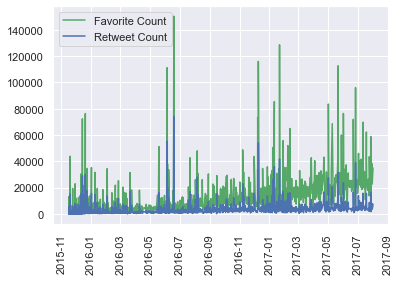

In [86]:
plt.plot(master_data.timestamp, master_data.favorite_count, color='g')
plt.plot(master_data.timestamp, master_data.retweet_count, color='b')
plt.legend([('Favorite Count'), ('Retweet Count')])
plt.xticks(rotation=90);

- It's clear that the favorite and retweet counts were increasing by time.

## What is the relationship between the rating and the number of tweets?

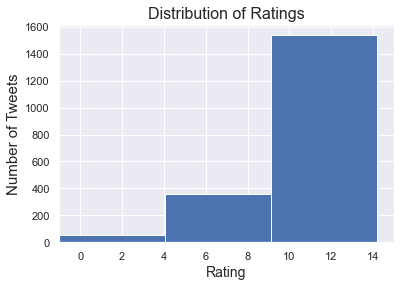

In [87]:
master_data['rating_numerator'].plot(kind = 'hist', bins = 15)

plt.xlim(-1, 15)
plt.ylabel('Number of Tweets', fontsize = 15)
plt.xlabel('Rating', fontsize = 14)
plt.title('Distribution of Ratings', fontsize = 16)
plt.show();

## How many tweets have favorite count <= retweet count?

In [88]:
sum(master_data.favorite_count <= master_data.retweet_count)

0

- All the tweets have favorite count higher than the retweets' count

## What are the top five tweets?

In [89]:
master_data.sort_values(by = 'favorite_count', ascending = False).head(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,is_dog
762,744234799360020481,2016-06-18 18:26:18,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13,None,doggo,74194,150369,...,Labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True,True
301,822872901745569793,2017-01-21 18:26:02,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super supportive puppo participating ...,https://twitter.com/dog_rates/status/822872901...,13,None,puppo,41830,128621,...,Lakeland_terrier,0.196015,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True,True
392,807106840509214720,2016-12-09 06:17:20,"<a href=""http://twitter.com/download/iphone"" r...",This is Stephan. He just wants to help. 13/10 ...,https://twitter.com/dog_rates/status/807106840...,13,Stephan,,54087,116059,...,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True,True
107,866450705531457537,2017-05-22 00:28:40,"<a href=""http://twitter.com/download/iphone"" r...",This is Jamesy. He gives a kiss to every other...,https://twitter.com/dog_rates/status/866450705...,13,Jamesy,pupper,31580,112675,...,French_bulldog,0.905334,True,Boston_bull,0.078060,True,pug,0.001771,True,True
796,739238157791694849,2016-06-04 23:31:25,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo blowing bubbles. It's downright...,https://twitter.com/dog_rates/status/739238157...,13,None,doggo,55295,111227,...,Eskimo_dog,0.503372,True,Siberian_husky,0.390413,True,malamute,0.080901,True,True


In [90]:
master_data.sort_values(by = 'retweet_count', ascending = False).head(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,is_dog
762,744234799360020481,2016-06-18 18:26:18,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13,None,doggo,74194,150369,...,Labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True,True
796,739238157791694849,2016-06-04 23:31:25,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo blowing bubbles. It's downright...,https://twitter.com/dog_rates/status/739238157...,13,None,doggo,55295,111227,...,Eskimo_dog,0.503372,True,Siberian_husky,0.390413,True,malamute,0.080901,True,True
392,807106840509214720,2016-12-09 06:17:20,"<a href=""http://twitter.com/download/iphone"" r...",This is Stephan. He just wants to help. 13/10 ...,https://twitter.com/dog_rates/status/807106840...,13,Stephan,,54087,116059,...,Chihuahua,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True,True
301,822872901745569793,2017-01-21 18:26:02,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super supportive puppo participating ...,https://twitter.com/dog_rates/status/822872901...,13,None,puppo,41830,128621,...,Lakeland_terrier,0.196015,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True,True
58,879415818425184262,2017-06-26 19:07:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Duddles. He did an attempt. 13/10 some...,https://twitter.com/dog_rates/status/879415818...,13,Duddles,,39021,96085,...,English_springer,0.383404,True,Boston_bull,0.134967,True,Cardigan,0.110481,True,True


- There are 3 tweets that are in the top 5 for both variables, but the most popular tweet is also the same as the most retweeted tweet.

## What is the most common dog breed?

In [91]:
master_data.dog_stage.value_counts()

                 1650
pupper            200
doggo              62
puppo              22
doggo-pupper        8
floofer             7
doggo-puppo         1
doggo-floofer       1
Name: dog_stage, dtype: int64

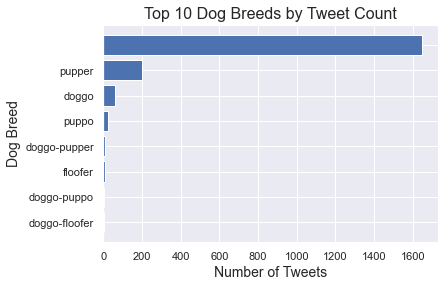

In [92]:
plt.barh(master_data.dog_stage.value_counts().index, master_data.dog_stage.value_counts().values)

plt.xlabel('Number of Tweets', fontsize = 14)
plt.ylabel('Dog Breed', fontsize = 14)
plt.title('Top 10 Dog Breeds by Tweet Count', fontsize = 16)
plt.gca().invert_yaxis()
plt.show();

- The bar chart above shows that the most common dog is pupper then doggo.
- Note: This data is not clear enough, it should be assessed and cleaned agian to give accurate values by filling empty vlaues

## Which dog breeds have the highest overall favorite counts?

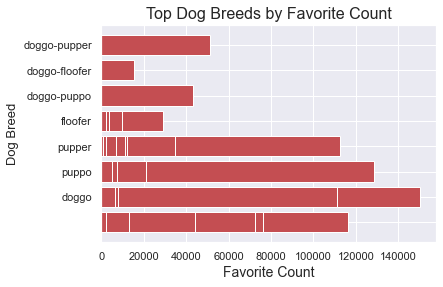

In [93]:
plt.barh(master_data.dog_stage, master_data.favorite_count, color = 'r')

plt.xlabel('Favorite Count', fontsize = 14)
plt.ylabel('Dog Breed', fontsize = 13)
plt.title('Top Dog Breeds by Favorite Count', fontsize = 16)
plt.show();

- The plot above shows the top dog breeds ranked by favorite counts. It displays that doggo dogs have the highest number of favorite counts also.